# Anomaly Detection of Tweets mentioning 'GOOG' tickr symbol

In [247]:
import numpy as np
import pandas as pd

from scipy.stats import entropy

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

from tensorflow import keras
from tensorflow.keras import layers

In [248]:
data = pd.read_csv('../data/archive/realTweets/realTweets/Twitter_volume_GOOG.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

data.head()

,timestamp,value
0,2015-02-26 21:42:53,35
1,2015-02-26 21:47:53,41
2,2015-02-26 21:52:53,32
3,2015-02-26 21:57:53,36
4,2015-02-26 22:02:53,32


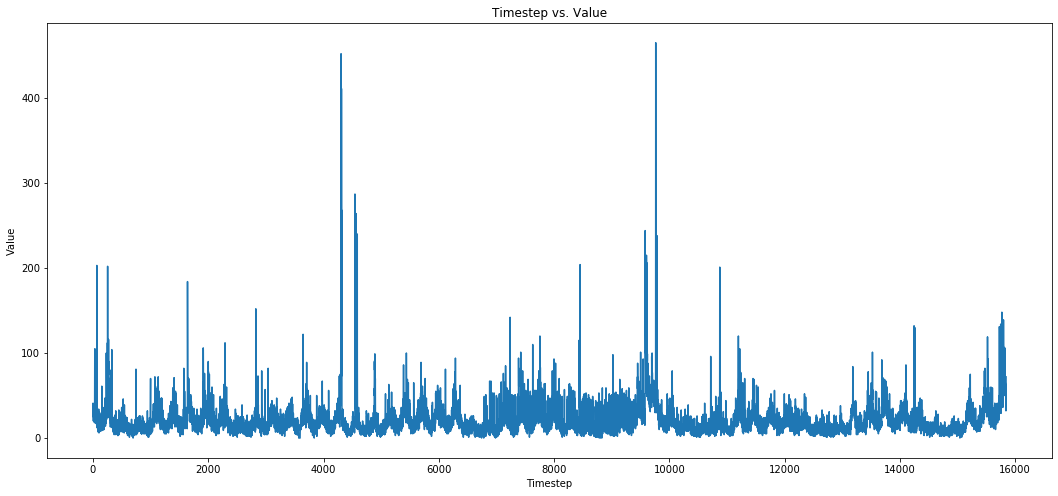

In [249]:
plt.gcf().set_size_inches(18, 8)

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('Timestep vs. Value')

data['value'].plot()

***
## Feature Engineering

### One Difference

In [250]:
data['one_difference'] = data['value'].diff()

data['one_difference'].loc[0] = data['value'].loc[0]

C:\Program Files\Python3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


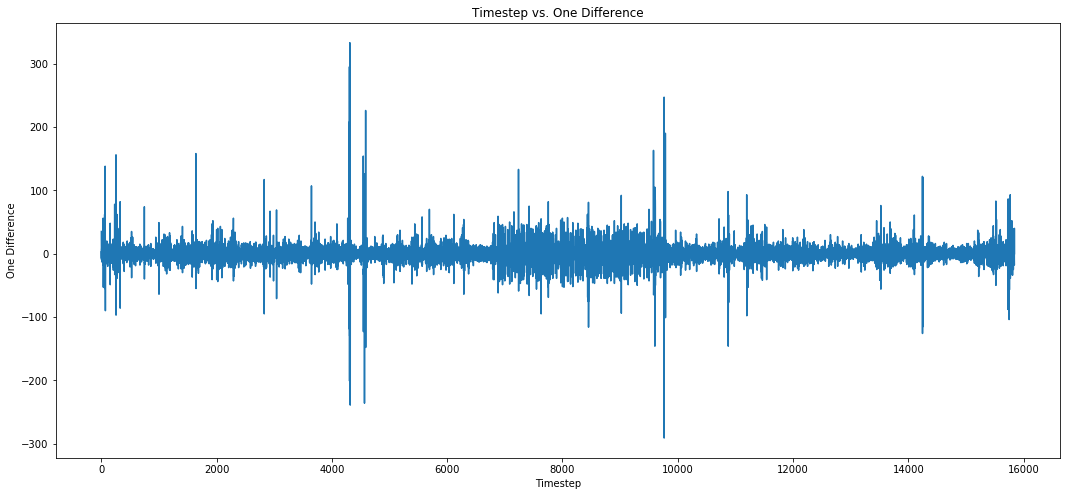

In [251]:
plt.gcf().set_size_inches(18, 8)

plt.xlabel('Timestep')
plt.ylabel('One Difference')
plt.title('Timestep vs. One Difference')

data['one_difference'].plot()

### Cummulative Sum

In [252]:
data['cum_sum'] = data['value'].cumsum()

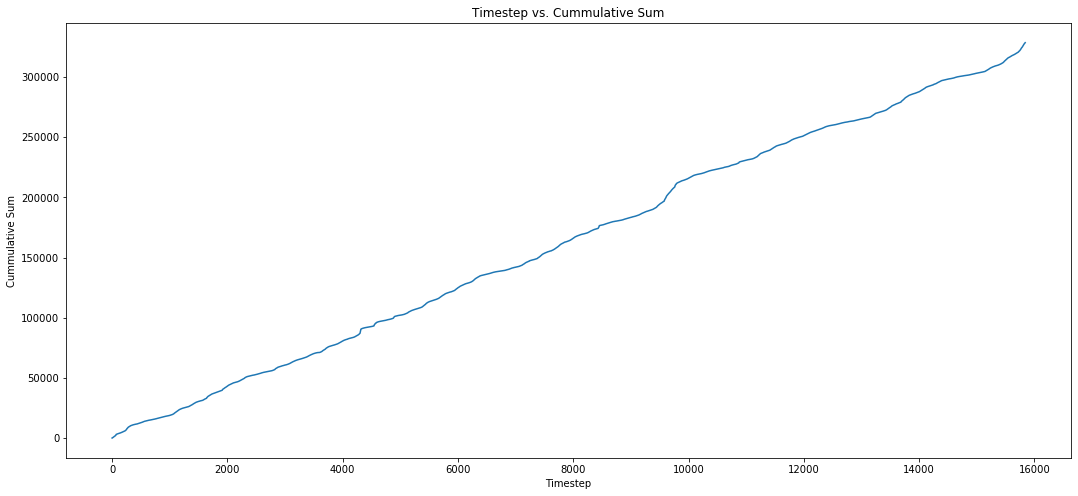

In [253]:
plt.gcf().set_size_inches(18, 8)

plt.xlabel('Timestep')
plt.ylabel('Cummulative Sum')
plt.title('Timestep vs. Cummulative Sum')

data['cum_sum'].plot()

### Entropy Window [1]

In [254]:
window_size = 15

data['entropy'] = data['value'].rolling(window_size).apply(lambda x: entropy(x.value_counts()))

data['entropy'].iloc[0:window_size] = data['entropy'].iloc[window_size]

C:\Program Files\Python3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


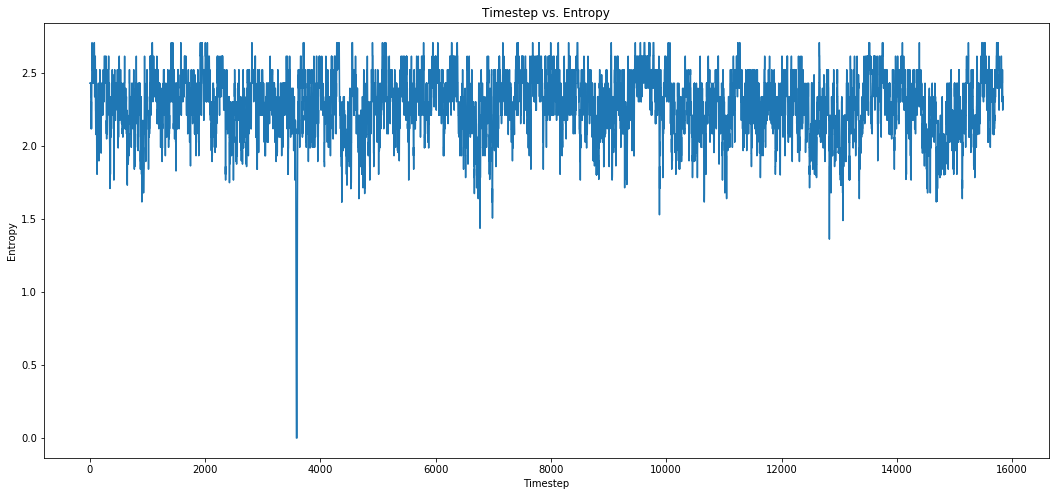

In [255]:
plt.gcf().set_size_inches(18, 8)

plt.xlabel('Timestep')
plt.ylabel('Entropy')
plt.title('Timestep vs. Entropy')

data['entropy'].plot()

***
## Anomaly Detection

### Isolation Forest classifier

In [256]:
iForest = IsolationForest(random_state=0)

iForest.fit(data[['value', 'one_difference', 'cum_sum', 'entropy']])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)

In [257]:
data['anomaly_score'] = iForest.decision_function(data[['value', 'one_difference', 'cum_sum', 'entropy']])
data['anomaly'] = iForest.predict(data[['value', 'one_difference', 'cum_sum', 'entropy']])

In [258]:
data[data['anomaly']==-1].sort_values(by=['anomaly_score']).iloc[0:15]

,timestamp,value,one_difference,cum_sum,entropy,anomaly_score,anomaly
4307,2015-03-13 20:37:53,224,130.0,88602,2.708050,-0.260436,-1
254,2015-02-27 18:52:53,202,156.0,7574,2.615631,-0.248706,-1
4311,2015-03-13 20:57:53,411,333.0,89412,2.615631,-0.247326,-1
4304,2015-03-13 20:22:53,452,295.0,87989,2.615631,-0.247326,-1
4317,2015-03-13 21:27:53,268,140.0,90559,2.615631,-0.245306,-1
4302,2015-03-13 20:12:53,276,208.0,87380,2.615631,-0.245306,-1
66,2015-02-27 03:12:53,187,138.0,2510,2.523211,-0.245169,-1
9785,2015-04-01 21:07:53,238,190.0,211058,2.615631,-0.243321,-1
4309,2015-03-13 20:47:53,227,133.0,88923,2.615631,-0.242789,-1
4305,2015-03-13 20:27:53,295,-157.0,88284,2.615631,-0.241116,-1


### One Class SVM classifier

In [259]:
data.drop(['anomaly_score', 'anomaly'], axis=1, inplace=True)

In [260]:
scaler = MinMaxScaler()

data[['value', 'one_difference', 'cum_sum', 'entropy']] = scaler.fit_transform(data[['value', 'one_difference', 'cum_sum', 'entropy']])

In [261]:
svmClassifier = OneClassSVM()

svmClassifier.fit(data[['value', 'one_difference', 'cum_sum', 'entropy']])

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [262]:
data['anomaly'] = svmClassifier.predict(data[['value', 'one_difference', 'cum_sum', 'entropy']])
data['anomaly_score'] = svmClassifier.score_samples(data[['value', 'one_difference', 'cum_sum', 'entropy']])

In [263]:
data[data['anomaly']==-1].sort_values(by=['anomaly_score']).iloc[0:15]

,timestamp,value,one_difference,cum_sum,entropy,anomaly,anomaly_score
4304,2015-03-13 20:22:53,0.972043,0.939103,0.267768,0.965872,-1,388.025773
9763,2015-04-01 19:17:53,1.000000,0.862179,0.637009,0.897617,-1,424.663354
4311,2015-03-13 20:57:53,0.883871,1.000000,0.272100,0.965872,-1,485.034715
3582,2015-03-11 08:12:53,0.000000,0.466346,0.216174,0.000000,-1,990.994519
3583,2015-03-11 08:17:53,0.000000,0.466346,0.216174,0.000000,-1,990.994519
3584,2015-03-11 08:22:53,0.000000,0.466346,0.216174,0.000000,-1,990.994519
3585,2015-03-11 08:27:53,0.000000,0.466346,0.216174,0.000000,-1,990.994519
3593,2015-03-11 09:07:53,0.000000,0.466346,0.216174,0.000000,-1,990.994519
3589,2015-03-11 08:47:53,0.000000,0.466346,0.216174,0.000000,-1,990.994519
3592,2015-03-11 09:02:53,0.000000,0.466346,0.216174,0.000000,-1,990.994519


***
## Analysis

From both the IsolationForest and OneClassSVM approaches, a high anomaly index is visible from the second week of March to the first week of April. After a quick fact-checking, I believe the spike in 'GOOG' tickr may have been because of an inconsistency with the stock dividends for Canadian investors. A news article [3] from around that time may have caused Twitter users to share the news through tweets mentioning 'GOOG' tickr symbol.



### References

[1] V. Fehst et al., GECCO '18: Proceedings of the Genetic and Evolutionary Computation Conference Companion, July 2018, Pages 5–6, https://doi.org/10.1145/3205651.3208204

[2] https://keras.io/examples/timeseries/timeseries_anomaly_detection/

[3] https://sdtimes.com/2lemetry/googles-multi-device-reference-app-amazons-acquisition-2elemtry-sd-times-news-digest-march-13-2015/